<center><h1> Assignment05 </h1></center>
<center>02/04/2025</center>
Oleksii Korduba (korduba@student.agh.edu.pl)

In this assignment I implemented iteration correction for MPDATA algorithm. MPDATA it is a numerical method designed to solve advection-dominated equaton. The idea is very simple: start with the upwind solution and apply corrective steps to reduce its diffusion.

In [19]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot

In [20]:
class Shift:
    def __init__(self, *, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, i):
        return slice(i.start + self.add, i.stop + self.add)
    def __rsub__(self, i):
        return slice(i.start - self.sub, i.stop - self.sub)

one = Shift(add=1, sub=1)
hlf = Shift(add=0, sub=1)

def F(psi_l, psi_r, C):
    return .5 * (C + abs(C)) * psi_l + \
           .5 * (C - abs(C)) * psi_r

def upwind(psi, i, C):
    psi[i] = psi[i] - (
        F(psi[i      ], psi[i + one], C[i + hlf]) -
        F(psi[i - one], psi[i      ], C[i - hlf])
    )

def psi_0(x: np.ndarray, x0: float = 0, a: float = 1, sigma: float = 20):
    return a * np.exp( - (x - x0)**2 / 2 / sigma**2)

In [21]:
def corrective_C(C:np.ndarray, i:slice, psi:np.ndarray ):
    return (abs(C[i - hlf]) 
            - np.pow(C[i - hlf], 2)) * ((psi[i] - psi[i - one]) / (psi[i] + psi[i - one]))
    # we can add eps here to not divide by 0

def solve_upwind(*, nt: int, C: np.ndarray, psi: np.ndarray):
    assert all(abs(C) < 1)
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
    return psi

def solve_mpdata(*, nt: int, C: np.ndarray, psi: np.ndarray, n: int = 1):
    for _ in range(nt):
        upwind(psi, slice(1, len(C)), C)
        C_new = C
        for _ in range(n):
            C_new = corrective_C(C_new, slice(1, len(psi)), psi)
            upwind(psi, slice(1, len(C)), C_new)
    return psi

In [22]:
u = 3
t_max = 50

nx = 50
nt = 500
dt = t_max / nt
x, dx = np.linspace(-100, 300, nx, retstep=True)

In [23]:
n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
result = []
for i in n:
    UPWIND=solve_upwind(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x))
    MPDATA=solve_mpdata(nt=nt, C=np.full(nx-1, u * dt / dx), psi=psi_0(x), n = i)
    result.append([n, UPWIND , MPDATA])

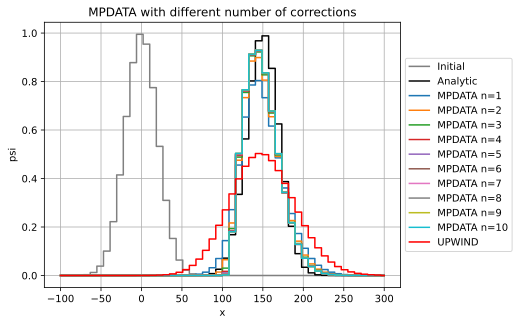

In [24]:
fig, ax = pyplot.subplots()
ax.step(x, psi_0(x), where='mid', label='Initial', color='gray')
ax.step(x, psi_0(x - u * t_max), where='mid', label='Analytic', color='black')
for i, (n_val, UPWIND, MPDATA) in enumerate(result):
    ax.step(x, MPDATA, where='mid', label=f'MPDATA n={n[i]}')

ax.step(x, result[0][1], where='mid', label='UPWIND', color='red')
ax.set_xlabel('x')
ax.set_ylabel('psi')
ax.set_title('MPDATA with different number of corrections')
ax.grid(True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
show_plot()

In the assignment I implemented iteration correction for MPDATA algorithm. As we can see from plot MPDATA with corrective iterations reduces and better preserves the shape to the initial condition. With 2-3 iterations MPDATA outperforms UPWIND, the other iterations brings only diminishing return.